# Logistic Regression 





<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/dist2d.png"
align = "left" width = "50%" height = "100%"
 style="float:right;width:5px;height:5px;">

<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shap.png"
align = "right" width = "50%" heigth = "20%"
 style="float:right;width:5px;height:5px;">
 <img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapAll.png"
align = "right" width = "50%" height = "20%"
 style="float:right;width:5px;height:5px;">

  <img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapEstEst.png"
align = "right" width = "50%" height = "40%"
 style="float:right;width:5px;height:5px;">


# Overview

In this notebook you will check:


1.   Data Visualization
2.   Build a Logistic Regression from scratch
3.   BootStrap Sampling with Confidence Interval (using Random Forest Classifier)
4.   Machine Learning Explainability: SHAP values



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from math import exp
import seaborn as sns
import plotly.graph_objects as go
import time
import random

random.seed(3)

!wget "https://drive.google.com/uc?id=15WAD9_4CpUK6EWmgWVXU8YMnyYLKQvW8&export=download" -O data.csv -q
# !wget "https://www.kaggle.com/danielfmfurlan/graduate-admission/data=download" -O data.csv -q
# Load the data
data = pd.read_csv("data.csv")
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [2]:
data.describe()

,User ID,Age,EstimatedSalary,Purchased
count,4.000000e+02,400.000000,400.000000,400.000000
mean,1.569154e+07,37.655000,69742.500000,0.357500
std,7.165832e+04,10.482877,34096.960282,0.479864
min,1.556669e+07,18.000000,15000.000000,0.000000
25%,1.562676e+07,29.750000,43000.000000,0.000000
50%,1.569434e+07,37.000000,70000.000000,0.000000
75%,1.575036e+07,46.000000,88000.000000,1.000000
max,1.581524e+07,60.000000,150000.000000,1.000000


# Lets take a look at some graphs to better visualize these statistics

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1163: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


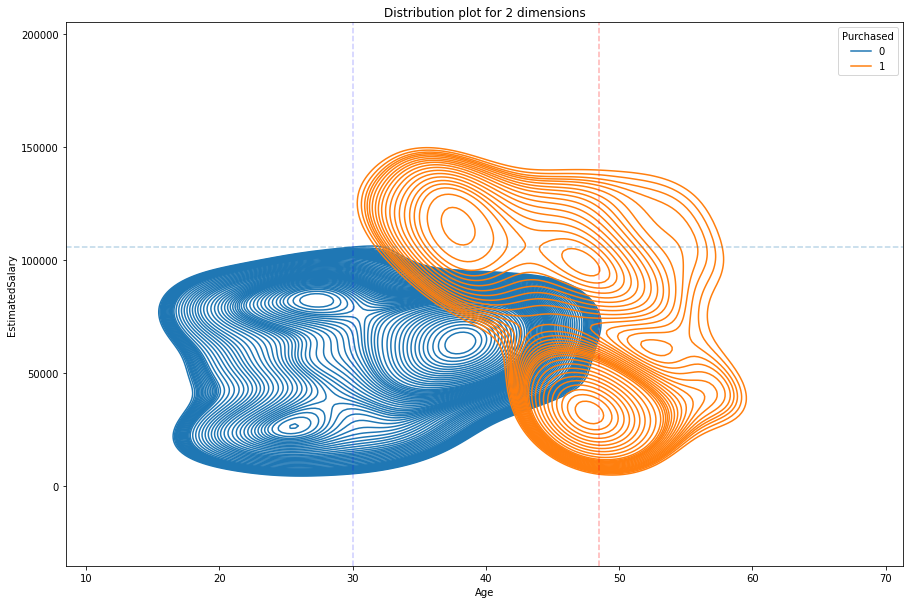

In [3]:
plt.figure(figsize=(15,10))
plt.title("Distribution plot for 2 dimensions")
sns.kdeplot(
    data=data, x="Age", y="EstimatedSalary", hue="Purchased",
    levels=75, thresh=0.2, fill = False, cmap = "mako"
)
sns.set_style("dark")
plt.axhline(y = 106000, alpha = 0.3,linestyle = "--")
plt.axvline(x = 30, alpha = 0.2,linestyle = "--", color = "blue")
plt.axvline(x = 48.5, alpha = 0.3,linestyle = "--", color = "red")

This is a nice plot telling us that while EstimatedSalary is a less discriminative variable (we can hardly distinguish if someone purchased based solely on it. The only region that we can do so is from above 106000 - the horizontal line -, where everyone purchased!), the Age has 2 separate regions: below 30y.o. and above 49 y.o. 

To have a better understanding of that, check the graph below.


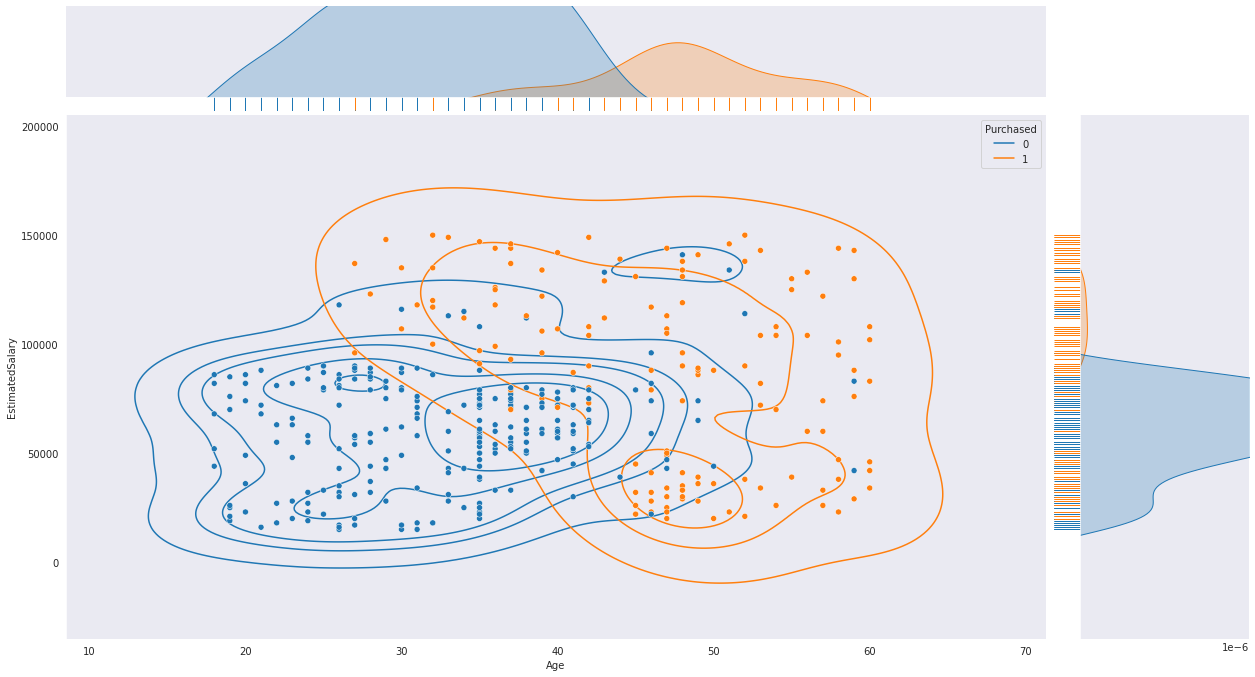

In [4]:

g = sns.jointplot(data=data, x="Age", y="EstimatedSalary", hue = "Purchased")

g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6)
g.plot_marginals(sns.rugplot, color="r", height=-0.15, clip_on=False)

plt.gcf().set_size_inches(19, 10)

Just for fun, let's try to visualize it in a 3D plot!

In [5]:
cols = np.sort(data.EstimatedSalary.unique())

dt = pd.DataFrame(index = [data.Age.unique()], columns = cols)
dt.sort_index(inplace=True)

val = len(data.loc[(data.Age == 50) & (data.EstimatedSalary == 28000)])


idx = dt.index.values

for col in cols:
  for age in idx:
    dt.loc[age,col] = len(data.loc[(data.Age == age[0]) & (data.EstimatedSalary == col)])

# dt

In [6]:
plt.figure(figsize=(15,10))
fig = go.Figure(data=[go.Surface(z=dt.values)])

fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))

fig.update_layout(title='3D plot distribution of Age and Estimated Salary', autosize=False,
                  width=1000, height=1000,
                  margin=dict(l=65, r=50, b=100, t=90))


fig.show()

<Figure size 1080x720 with 0 Axes>

<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/newplot (7).png"
align = "left" width = "50%">
 <img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/newplot (11).png"
align = "right" width = "50%">

REMARK: you may have noticed that the axes values are not correspondent to the real values! This is because it's taking as input the length of the variables and not their discrete values! In other words, the values were somehow scaled! 

What about the gender and Age? 

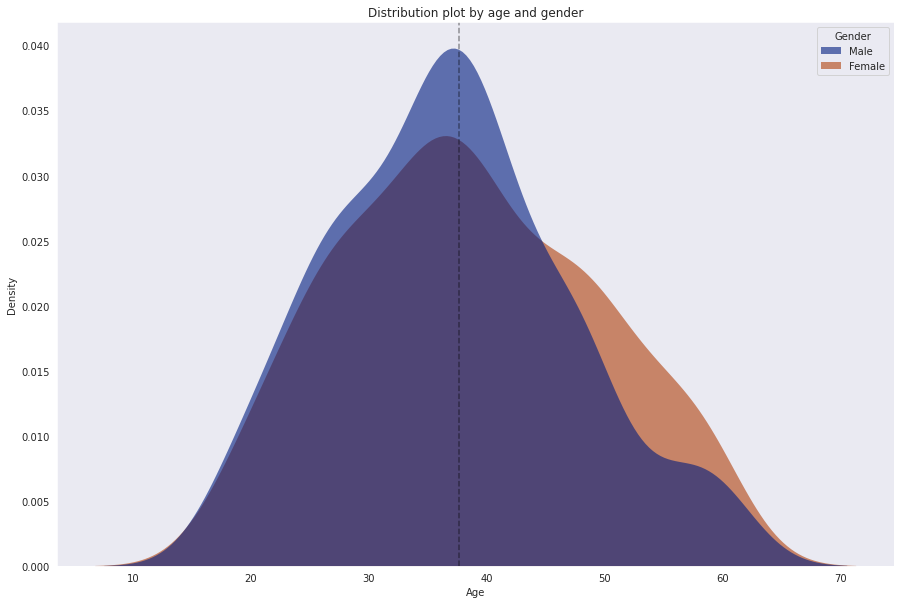

In [7]:
plt.figure(figsize=(15,10))
plt.title("Distribution plot by age and gender")
sns.kdeplot(
   data=data, x="Age", hue="Gender",
   fill=True, common_norm=False, palette="dark",
   alpha=.6, linewidth=0,
)
plt.axvline(data.Age.mean(), alpha = 0.4, color = "black", linestyle = '--', label = "Age mean")

Age and Gender have approximately the same distribution. That means a dataset well balanced for these variables. The dashed black vertical line is the mean of Age (considering both genders)

Lets now proceed to train a model and see how it can perform with a simple Logist Regression approach. The idea is to classify if someone will purchase or not based on one or more variables of interest.

In [8]:
# Divide the data to training set and test set
# Multivariate model:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:,['Age',"EstimatedSalary"]], data['Purchased'], test_size=0.20)
# Univariate model: 
# X_train, X_test, y_train, y_test = train_test_split(data.loc[:,["EstimatedSalary"]], data['Purchased'], test_size=0.20)

The variables that I will take into account here are Age and EstimatedSalary. So this is the data that our model will take in order to predict if someone will purchase.

I will train with 320 samples and test the model on 80!

In [9]:
X_train.shape, X_test.shape
# y_train.shape

((320, 2), (80, 2))

Time consumed :  0.786


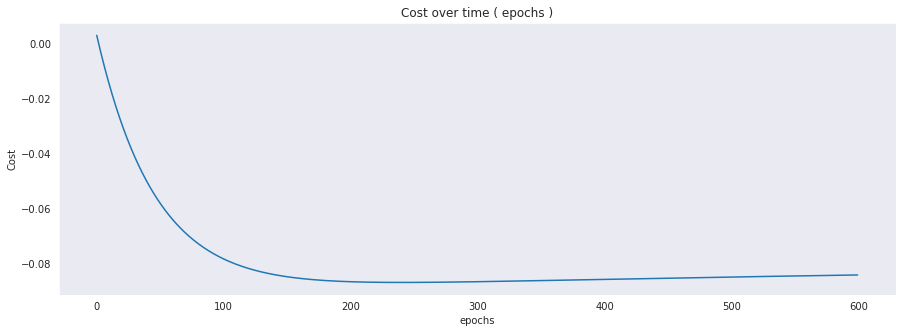

In [10]:
import math

def prediction(X,theta,mode):
    if mode == "batch":
        return np.array([1/(1 + exp(-(np.dot(x,theta))))for x in X])

    elif mode == "stoc":
        return 1/(1 + exp(-(theta[0] + theta[1]*x)))


def cost(x, y, theta,mode,pred):
    m = x.shape[0]
    
    if mode == "batch":
        return (1/m) * sum(np.transpose(y).dot(np.log(pred)) + (1 - np.transpose(y).dot(np.log(1 - pred))))
#     elif mode == "stoc":
        
def grad(x,y,theta,mode):
    epochs = 600   
    lr = 0.03
    m = x.shape[0]
    y = np.reshape(y,(y.shape[0],1))

    if x.shape[1] < 1:
      xb = np.reshape(x, (x.shape[0],1))
      xb = np.append(np.ones((xb.shape[0],1)),xb,axis=1)

    else:
      xb = np.append(np.ones((x.shape[0],1)),x,axis=1)

    J = []
    theta = np.array(np.zeros(xb.shape[1])).reshape((xb.shape[1],1))

    for _ in range(epochs):
        if mode == "batch":
            # display(type(x))
            pred = prediction(xb,theta,"batch")
            pred = np.reshape(pred,(pred.shape[0],1))

            error = 1/(2*m)*np.transpose((pred - y)).dot(xb)
            theta = theta - lr*np.reshape(error, (xb.shape[1],1))

            J.append(cost(xb,y,theta,"batch",pred)[0])

        elif mode == "stoc":
#             print("Our initial theta : ", theta)
            for i in range(m):
                pred = prediction(x[i],theta,"stoc")
                J.append((1/(2) * (y[i] - pred)**2))
                temp0 =1/m *(pred - y[i])
                temp1 = 1/m * (pred - y[i])*x[i]

                theta = theta - np.array([[temp0[0]],[temp1[0]]])*lr

    plt.figure(figsize=(15,5))
    plt.plot(J)
    plt.title("Cost over time ( epochs )")
    plt.ylabel("Cost")
    plt.xlabel("epochs")
    return theta,xb,y

x = np.array(X_train)
y = np.array(y_train)
x.shape
x = x/x.mean()
x
st = time.time()
t,x,y = grad(x,y,0,"batch")
end = time.time()
print("Time consumed : ", np.round((end-st), 3))
# grad(x,y,0,"stoc")

Now let's define a good threshold to establish which will be the value upon our model characterizes a sample as 1 or 0 (purchased or not purchased). First of all, check the balance of such values in our data: 😲

In [11]:
data.Purchased.value_counts()

0    257
1    143
Name: Purchased, dtype: int64

We can see that we have an umbalanced dataset, with near twice samples labeled 0. That said, we can't simple use a value of 0.5 for our threshold. Let's take a look at our predictions statistics to better know where the majority of them falls in: 🤽

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Predictions mean :  0.424 
Predictions min value :  0.363 
Predictions maximum value :  0.513 
Predictions standard deviation :  0.038 
Predictions median :  0.423 
Predictions 3rd quartile:  0.443


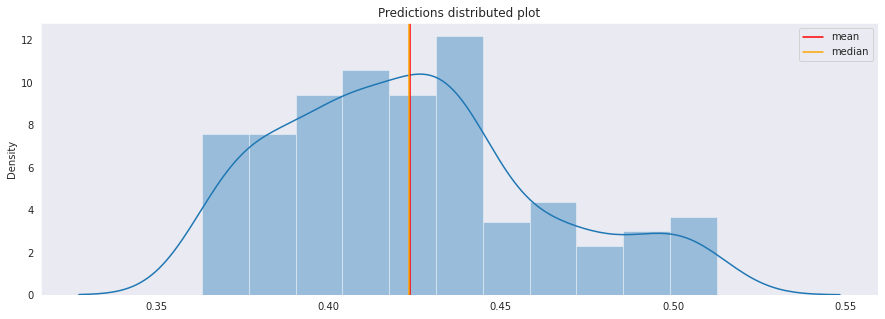

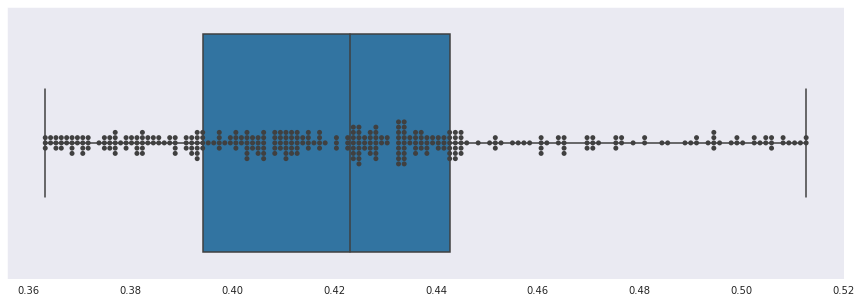

In [12]:
import seaborn as sns
import statistics

pred = prediction(x,t,"batch")

plt.figure(figsize=(15,5))
sns.distplot(pred, kde=True)
plt.axvline(x=pred.mean(),
            color='red', label = "mean")

plt.axvline(x=statistics.median(pred),
            color='orange', label = "median")

plt.legend()
plt.title("Predictions distributed plot")
plt.figure(figsize=(15,5))
sns.boxplot(pred)
sns.swarmplot(pred,color=".25")


# pred = np.array([1 if x >= 0.5 else 0 for x in pred])
print("Predictions mean : ", np.round(pred.mean(),3),"\nPredictions min value : ", np.round(pred.min(),3),"\nPredictions maximum value : ", np.round(pred.max(),3),"\nPredictions standard deviation : "
      , np.round(pred.std(),3),"\nPredictions median : ",np.round(statistics.median(pred),3),"\nPredictions 3rd quartile: ",np.round(np.quantile(pred,0.75),3))
# pred = np.array([1 if x >= pred.mean() else 0 for x in pred])


Ok! So that means 75% of our predictions are below the value of 0.445! If we have a ratio between positive and negative values of 143/257 = 0.56 (or 257/400 = 0.64 -> where 400 is the total samples in the dataset) we should take a threshold value near of the 3rd quartile so to cover the "most part of our positive cases" (in a statistical term) in the whole dataset. 


Would this interpretation be correct? You to think about it! ⛹

In [13]:
pred = np.array([1 if x >= np.quantile(pred,0.75) else 0 for x in pred])

y = np.reshape(y,(y.shape[0],))
a = np.sum(y == pred) / len(y)
print("Our final accuracy for training  : ", np.round(a,3))

xt = np.array(X_test)
yt = np.array(y_test)

xt = xt/xt.mean()
xt = np.append(np.ones((xt.shape[0],1)),xt,axis=1)

predtest = prediction(xt, t, "batch")
predtest = np.array([1 if x >= np.quantile(predtest,0.75) else 0 for x in predtest])
yt = np.reshape(yt,(yt.shape[0],))
at = np.sum(yt == predtest)/len(yt)
print("Our final accuracy for test : ", np.round(at,3))

Our final accuracy for training  :  0.781
Our final accuracy for test :  0.762


# BootStrap Sampling

What if we want to do a bootstrap sampling? Learn and test several times models in smaller portions of the dataset? This is quite convinient for big dataset (not the case here) and is always an interest approach.

In this case, I'm gonna use a Decision Tree Classifier. Is a fast dirty model that can easily learn. It can be used both for Classification and Regression problems!

Advantages: 

1.   Low computational cost
2.   Little data preparation

Disavantages:

1.   Can easily overfit, thus, not generalizing well
2.   Find the optmum decision tree can lead to a non global solution (falling in a local solution) -> can be mitigated by using a bag of trees (e.g. Random Forest Classifier)
3.   Necessary to balance the data, otherwhise, it will be biased!





I will thus perform a bootstrap sampling with only 10% of the dataset!! 
Our model will learn the data with only 40 samples!! The idea is to grab randomly 40 samples of the whole dataset with replacement (these samples can be chosen in the next time)

We repeat this process 10 times and reach an accuracy of 84% and near 95% of time ⏰ reduction!!

In [14]:
#### Bootstrap sampling

from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import time
import random

# random.seed(1234)

iter = 10 #### design sampling

stats = []

x = data.loc[:,["Age","EstimatedSalary","Purchased"]]
n_size = int(0.1*len(x))

x = x.values

st = time.time()
for _ in range(iter):

  train = resample(x,n_samples=n_size)

  test = np.array([row for row in x if row.tolist() not in train.tolist()])#.reshape((200,1))

  model = DecisionTreeClassifier(random_state = 1234)
  model.fit(train[:,:-1],train[:,-1])

  pred = model.predict(test[:,:-1])
  score = accuracy_score(test[:,-1],pred)
  # score
  stats.append(score)

end = time.time()
print("Time consumed : ", np.round((end - st),3))

Time consumed :  0.046


⏰

Mean of accuracies :  0.836 
Standard Deviation of accuracies :  0.038


<Figure size 1080x720 with 0 Axes>

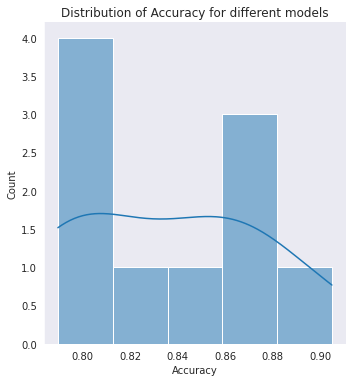

In [15]:
plt.figure(figsize=(15,10))
sns.displot(stats,kde=True).set(title = "Distribution of Accuracy for different models").set(xlabel="Accuracy")
print("Mean of accuracies : ",np.round(np.mean(stats),3),"\nStandard Deviation of accuracies : ", np.round(np.std(stats),3))

# Confidence Interval

It may be important, when performing statistical analyses, to consider a maring of error because we performances can always vary as the data been used can be different and so the model's parameters (like its weights). That said, we can't say or model will always have 84% of accuracy. It can vary as you saw in the graph above.

To do so, as the parameter of interest here is the mean of the accuracies over this repeated process, we shall use the t-Student distribution.


That said, our estimated accuracry for our entire population will be:

  EstAcc = MeanAcc +- t * std / sqrt(n)

  or

  EstAcc = MeanAcc +- MoE

where:

*   MeanAcc is the mean of the accuracies calculated previously
*   t is the value obtained from the table below
*   std is the Standard Deviation calculated previously
*   n is the size of our sample (10% of the dataset = 40 samples)
*   MoE is the "margin of error"

to get the t value: we set a confidence interval (95%) and the degree of freedom (n - 1 = 39)


---
<img src = "https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/t-table.png" align = "center" width = "1000" >


---
t ~ 2.022

MoE = 2.022 * 0.045 / sqrt(40)

MoE = 0.014 (1.4%)

EstAcc = 84% +- 1.4%

We can say thus: 
With 95% confidence we can say that the accuracy of the model representing the whole dataset will fall in the interval 82.6% and 85.4%

In other words, if we repeat this process many times, each of them grabing randomly 40 samples of the whole dataset, we would have for 95% of the cases a mean accuracy falling in between 82.6% and 85.4%

(For the sake of simplicity, we are assuming that we have at least 10 positive cases and 10 negative cases in each bag of the 40 sampes. Furthermore, we assume that our accuracies follow a normal distribution)


In [16]:
# !pip install shap

# Machine Learning Explainability

Great about the results. And what if we wanted to understand a bit more of how the model is deciding to which label a sample belongs?

How to explain a decision made by the model?

SHAP values are an interesting approach to observe how each feature/variable of any sample is contributing to the decision.
Take a look at it!

In [17]:
feature_cols = ["Age", "EstimatedSalary"]

In [18]:
#@title Texto de título padrão
import shap
shap.initjs()

train = resample(x,n_samples=n_size, random_state = 1234)

test = np.array([row for row in x if row.tolist() not in train.tolist()])#.reshape((200,1))

model = DecisionTreeClassifier(random_state = 1234)
model.fit(train[:,:-1],train[:,-1])

explainer = shap.KernelExplainer(model.predict_proba, train[:,:2])
shap_values = explainer.shap_values(test[:,:2])
shap.force_plot(explainer.expected_value[0], shap_values[0], test[:,:2], feature_names = feature_cols)

  0%|          | 0/353 [00:00<?, ?it/s]


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapAll.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

How to interpret such values?

First of all: 
1.   red means high contribution to label 1 (positive case. Purchased in our case).
2.   blue means high contribution to label 0 (negative case. Not purchased)

Secondly: the order ot the samples in this case is assembled by SIMILARITY!! You can change it in the horizontal bar.

Finally:

the width of the colored portions are proportional to how important was that feature to make the model decide. Actually, is all about the values. 
For instace, the first *127 - 350* samples have both the features (*Age* and *EstimatedSalary*) contributing solely for a high output (remember that our output is a float number between 0 and 1 from our sigmoid function. We convert then this number to integer 0 or 1 according to a threshold). They were all labeled as 1 (Purchased).

On the other hand, samples ranging from *0 - 76* have **Age** pushing the value to a negative case and **EstimatedSalary** to a positive case! 
But they haven't enough weight compared to **Age** (netly visible by the difference of width). They were labeled as 0 (not purchased).

From *94 - 127* we still have samples labeled as 0 but notice that interestingly, the feature importance switched: *EstimatedSalary* pushing the value to a negative label (0) and *Age* to a positive label (1)!

To a further interpreation of why this is happening, we should take a look at the spread of such samples with respect to the corelation between *Age* and *EstimatedSalary*.

What if we want to see the effect of *Age* through all its possible values? Check below!

In [19]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], test[:,:2], feature_names = feature_cols)


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapAge.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

In order to have this image, you just need to switch the horizontal bar to "Age". 

Quite interesting to notice that while *Age* ranging from *18* to *42* contribute greatly to a *positive* label (1), *Age* above *42* contribute greatly to a *negative* lavel (0). This image is telling us that people with *Age* more than *45* tend to not buy. 

I would not take that as granted. Simply because we are dealing with a modelizatino taking into account 2 variables! That said, our model learned the *behaviour* of our data looking at the relation between *Age* and *EstimatedSalary*. 

Nevertheless, is an indicator.

Lets try to see how the *Age* is related to *EstimatedSalary*. We can switch the vertical bar to "Age effect" and the horizontal one to "EstimatedSalary". That said, we're now looking at how much *effect* *Age* has on the output value through different values of *EstimatedSalary*:

In [20]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], test[:,:2], feature_names = feature_cols)


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapAgeEffeSal.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

Would you expect that people earning more would be prone to buy more? Not that simple:
Let's check all the red portions, where the *Age* contributed to a positive label (1)

The very first red portion tell us that:

*   *EstimatedSalary* ranging from *15000* to *19000* (the lowest in the data) had a mean *Age* ranging from *26* to *32* y.o. 

The second/third red portion:
*   *EstimatedSalary* ranging from  *51000* and *72000* ana a mean *Age* ranging from *25* to *38* yo.

The fourth red portion:
*   *EstimatedSalary* ranging from  *78000* and *80000* ana a mean *Age* ranging from *31* to *37* yo.

The fifth red portion:
*   *EstimatedSalary* ranging from *84000* to *86000* and a mean *Age* ranging from *25* to *27* y.o.

---

Let's now check some blue portions, where the *Age* contributed to a negative label (0)

The very first blue portion tell us that:
*   *EstimatedSalary* ranging from *19000* to *27000* had a mean *Age* ranging from *32* to *42* y.o. 

The second blue portion:
*   *EstimatedSalary* ranging from  *27000* and *31000* and a mean *Age* ranging from *30* to *48* yo.

The third blue portion:
*   *EstimatedSalary* ranging from  *31000* and *43000* and a mean *Age* ranging from *35* to *51* yo.

The greatest effect of *Age* pushing the model to label negative (not purchased), was observed at the pairs (*Age-EstimatedSalary*) **52**-**114000** and **60**-**102000**.


Take a look at the inverse relation now. How much effect has *EstimatedSalary* on the output through all the ages 

In [21]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], test[:,:2], feature_names = feature_cols)


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapEstEffAge.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

The greatest effect of *EstimatedSalary* pushing the model to label negative (not purchased), was observed at pair (*Age-EstimatedSalary*) **43**-**124000**

And if we took a look at the effect of *EstimatedSalary* on the final output throug all the *EstimatedSalary* values?

In [22]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], test[:,:2], feature_names = feature_cols)


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shapEstEst.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

Uhm... interesting to observe that:


1.   Salary ranging from *15000* to *122000* contributed to a positive label (1) - purchased with only two exceptions from **65000** to **70000** and from **76000** to **80000**
2.   Salary from *122000* and above contributed to a **negative** label (0)

We can conclude than that people earning **MORE** don't necessarily purchase more in the used dataset.



What about a single prediction? Take a look at the next image.

In [23]:
shap.initjs()
data_for_prediction =test[20,:2]
data_ser = data_for_prediction.reshape(1, -1)
shap_values = explainer.shap_values(data_ser)
shap.force_plot(explainer.expected_value[1], shap_values[1], data_ser, feature_names = feature_cols)

  0%|          | 0/1 [00:00<?, ?it/s]


<img src="https://raw.githubusercontent.com/danielfurlan/aisite/master/LogisticRegression/shap.png"
align = "center" width = "100%" height = "100%"
 style="float:right;width:5px;height:5px;">

For the sample number 20th in our test dataset, we have this distribution of importance.

An *Age* of **49** and an *EstimatedSalary* of **28000** were labeled as 1 (purchased). And you can see how important was the *Age* in this decision: it had almost *15* (~75/5) times the importance of *EstimatedSalary*

# Conclusion

We can conclude from the explanations above that while *EstimatedSalary* plays a role in the **particular** model used (*Random Forest Classifier* **with** a **single sampling** of sample size of **40**) *Age* showed to play a major role when predicting if "someone" would purchase or not.


Still, we observed some particular stratifications either considering *Age* or *EstimatedSalary* (e.g. *15000* to *19000* had a mean *Age* of *26* to *32* and a *positive* label)


Keep in mind that if you run this model again with different *random_state* (meaning a different seed to the random generator) you'll have DIFFERENT results!


Moreover, if you use a different model, you'll have DIFFERENT results!

That said, this is a tiny explanation of what this *dataset* **would** represent.

